# 1.Viewing information of Datacube 

In [1]:
import os,sys
from datacube.config import LocalConfig
sys.path.append(os.environ['odc_config'])
import datacube
from utils.data_cube_utilities import dc_display_map
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

list_of_products = dc.list_products()
netCDF_products = list_of_products[list_of_products['format'] == 'NetCDF']
netCDF_products

,name,description,product_type,format,label,lat,platform,time,lon,creation_time,instrument,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
4,fs2_ms_nspo_aogu,FS2 proessed by NSPO Resampled to 8m EPSG:4326...,NSPOortho,NetCDF,None,None,FS2_MS_NSPO,None,None,None,R1M,EPSG:4326,"(-7.8365e-05, 7.8365e-05)","(0.25928, 0.25928)","(latitude, longitude)"
2,fs2_ms_nspo_general,FS2 proessed by NSPO Resampled to 8m EPSG:4326...,NSPOortho,NetCDF,None,None,FS2_MS_NSPO,None,None,None,R1M,EPSG:4326,"(-7.8365e-05, 7.8365e-05)","(0.25928, 0.25928)","(latitude, longitude)"
3,fs2_ms_nspo_masadi,FS2 proessed by NSPO Resampled to 8m EPSG:4326...,NSPOortho,NetCDF,None,None,FS2_MS_NSPO,None,None,None,R1M,EPSG:4326,"(-7.8365e-05, 7.8365e-05)","(0.25928, 0.25928)","(latitude, longitude)"
5,fs2_ms_nspo_thailand,FS2 proessed by NSPO Resampled to 8m EPSG:4326...,NSPOortho,NetCDF,None,None,FS2_MS_NSPO,None,None,None,R1M,EPSG:4326,"(-7.3756e-05, 7.3756e-05)","(0.25928, 0.25928)","(latitude, longitude)"
7,fs5_ms_nspo_general,FS5 proessed by NSPO Resampled to 4m EPSG:4326...,NSPOortho,NetCDF,None,None,FS5_MS_NSPO,None,None,None,R1M,EPSG:4326,"(-3.91825e-05, 3.91825e-05)","(0.25928, 0.25928)","(latitude, longitude)"
12,fs5_ms_nspo_rice,FS5 proessed by NSPO Resampled to 4m EPSG:4326...,NSPOortho,NetCDF,None,None,FS5_MS_NSPO,None,None,None,R1M,EPSG:4326,"(-3.91825e-05, 3.91825e-05)","(0.25928, 0.25928)","(latitude, longitude)"
9,ls7_C1_sr_taiwan,Landsat 7 USGS Collection 1 Level2 Surface Ref...,LEDAPS,NetCDF,None,None,LANDSAT_7,None,None,None,ETM,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"
11,ls8_C1_sr_taiwan,Landsat 8 USGS Collection 1 Level2 Surface Ref...,LaSRC,NetCDF,None,None,LANDSAT_8,None,None,None,OLI_TIRS,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"


In [2]:
list_of_products #list product

,name,description,product_type,format,label,lat,platform,time,lon,creation_time,instrument,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
4,fs2_ms_nspo_aogu,FS2 proessed by NSPO Resampled to 8m EPSG:4326...,NSPOortho,NetCDF,None,None,FS2_MS_NSPO,None,None,None,R1M,EPSG:4326,"(-7.8365e-05, 7.8365e-05)","(0.25928, 0.25928)","(latitude, longitude)"
2,fs2_ms_nspo_general,FS2 proessed by NSPO Resampled to 8m EPSG:4326...,NSPOortho,NetCDF,None,None,FS2_MS_NSPO,None,None,None,R1M,EPSG:4326,"(-7.8365e-05, 7.8365e-05)","(0.25928, 0.25928)","(latitude, longitude)"
3,fs2_ms_nspo_masadi,FS2 proessed by NSPO Resampled to 8m EPSG:4326...,NSPOortho,NetCDF,None,None,FS2_MS_NSPO,None,None,None,R1M,EPSG:4326,"(-7.8365e-05, 7.8365e-05)","(0.25928, 0.25928)","(latitude, longitude)"
5,fs2_ms_nspo_thailand,FS2 proessed by NSPO Resampled to 8m EPSG:4326...,NSPOortho,NetCDF,None,None,FS2_MS_NSPO,None,None,None,R1M,EPSG:4326,"(-7.3756e-05, 7.3756e-05)","(0.25928, 0.25928)","(latitude, longitude)"
1,fs2_ms_nspo_toa_scene,FORMOSAT 2 MS NSPO TOA scene,NSPOortho,GeoTiff,None,None,FS2_MS_NSPO,None,None,None,R1M,NaN,NaN,NaN,NaN
7,fs5_ms_nspo_general,FS5 proessed by NSPO Resampled to 4m EPSG:4326...,NSPOortho,NetCDF,None,None,FS5_MS_NSPO,None,None,None,R1M,EPSG:4326,"(-3.91825e-05, 3.91825e-05)","(0.25928, 0.25928)","(latitude, longitude)"
12,fs5_ms_nspo_rice,FS5 proessed by NSPO Resampled to 4m EPSG:4326...,NSPOortho,NetCDF,None,None,FS5_MS_NSPO,None,None,None,R1M,EPSG:4326,"(-3.91825e-05, 3.91825e-05)","(0.25928, 0.25928)","(latitude, longitude)"
6,fs5_ms_nspo_toa_scene,FORMOSAT 5 MS NSPO TOA scene,NSPOortho,GeoTiff,None,None,FS5_MS_NSPO,None,None,None,R1M,NaN,NaN,NaN,NaN
8,ls7_C1_sr_scene,Landsat 7 USGS Collection 1 Level2 Surface Ref...,LEDAPS,GeoTiff,None,None,LANDSAT_7,None,None,None,ETM,NaN,NaN,NaN,NaN


In [3]:
#list_of_measurements = dc.list_measurements('ls7_lasrc_taiwan')
list_of_measurements = dc.list_measurements()
list_of_measurements

aliases  \
product               measurement                                              
fs2_ms_nspo_aogu      blue                                    [band_3, blue]   
                      green                                  [band_2, green]   
                      red                                      [band_1, red]   
                      nir                                      [band_4, nir]   
                      pixel_qa                                    [pixel_qa]   
fs2_ms_nspo_general   blue                                    [band_3, blue]   
                      green                                  [band_2, green]   
                      red                                      [band_1, red]   
                      nir                                      [band_4, nir]   
                      pixel_qa                                    [pixel_qa]   
fs2_ms_nspo_masadi    blue                                    [band_3, blue]   
                      green                                  [band_2, green]   
                      red                                      [band_1, red]   
                      nir                                      [band_4, nir]   
                      pixel_qa                                    [pixel_qa]   
fs2_ms_nspo_thailand  blue                                    [band_3, blue]   
                      green                                  [band_2, green]   
                      red                                      [band_1, red]   
                      nir                                      [band_4, nir]   
                      pixel_qa                                    [pixel_qa]   
fs2_ms_nspo_toa_scene TOA_band3                               [band_3, blue]   
                      TOA_band2                              [band_2, green]   
                      TOA_band1                                [band_1, red]   
                      TOA_band4                                [band_4, nir]   
                      pixel_qa                                    [pixel_qa]   
fs5_ms_nspo_general   blue                                    [band_3, blue]   
                      green                                  [band_2, green]   
                      red                                      [band_1, red]   
                      nir                                      [band_4, nir]   
                      pixel_qa                                    [pixel_qa]   
...                                                                      ...   
ls7_C1_sr_taiwan      blue                                [band_1, sr_band1]   
                      green                               [band_2, sr_band2]   
                      red                                 [band_3, sr_band3]   
                      nir                                 [band_4, sr_band4]   
                      swir1                               [band_5, sr_band5]   
                      swir2                               [band_7, sr_band7]   
                      sr_atmos_opacity                            [atmos_op]   
                      sr_cloud_qa                                 [cloud_qa]   
                      pixel_qa                                    [pixel_qa]   
                      radsat_qa                                  [radsat_qa]   
ls8_C1_sr_scene       coastal_aerosol                     [band_1, sr_band1]   
                      blue                                [band_2, sr_band2]   
                      green                               [band_3, sr_band3]   
                      red                                 [band_4, sr_band4]   
                      nir                                 [band_5, sr_band5]   
                      swir1                               [band_6, sr_band6]   
                      swir2                               [band_7, sr_band7]   
                      pixel_qa                                    [pi

In [5]:
import data_access_api as dc_api  
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')

platform = "LANDSAT_8"
product = "ls8_C1_sr_taiwan"

# Get Coordinates
coordinates = api.get_full_dataset_extent(platform = platform, product = product)
times = coordinates["time"].values 

latitude_extents = (min(coordinates['latitude'].values),max(coordinates['latitude'].values))
print( latitude_extents )
longitude_extents = (min(coordinates['longitude'].values),max(coordinates['longitude'].values))
print( longitude_extents )

(20.58979055390826, 27.072482801760238)
(118.25624521094608, 123.17667734818497)


In [6]:
times

array(['2013-04-16T02:22:14.257149000', '2013-04-16T02:22:38.156658000',
       '2013-04-16T02:23:02.056168000', ...,
       '2019-08-30T02:27:11.543854000', '2019-08-30T02:27:35.443365000',
       '2019-08-30T02:27:59.338640000'], dtype='datetime64[ns]')

# 2.Loading data from Datacube

In [3]:
import datetime

#lon,lat -> sample
#lon2, lat2 -> city
#lon3, lat3 -> wild

# define geographic boundaries in (min, max) format
lon = (120.972549, 121.511577)
lat = (24.783987, 25.307047)
lon2 = (121.517930,121.511006)
lat2 = (25.016561,25.009717)
lon3 = (121.427809, 121.422123)
lat3 = (24.951064, 24.946710)

In [5]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = lat3, longitude = lon3)

In [10]:
date_range =(datetime.datetime(2015,1,1), datetime.datetime(2015,2,28))
# define product and platform to specify our intent to load Landsat 8 sr products
platform = 'LANDSAT_8'
product = 'ls8_C1_sr_taiwan'  
# define desired bands. 
desired_bands = ['red','green','blue','nir','swir1','swir2','pixel_qa']  

# load area. Should result in approximately 15 acquisitions between 2014 and 2016      
landsat = dc.load(product = product,platform = platform,lat = lat,lon = lon, time = date_range,measurements = desired_bands,group_by = 'solar_day')

In [11]:
landsat

<xarray.Dataset>
Dimensions:    (latitude: 1942, longitude: 2001, time: 7)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-07T02:26:39.138373 ... 2015-02-24T02:26:24.238678
  * latitude   (latitude) float64 25.31 25.31 25.31 25.31 ... 24.78 24.78 24.78
  * longitude  (longitude) float64 121.0 121.0 121.0 121.0 ... 121.5 121.5 121.5
Data variables:
    red        (time, latitude, longitude) int16 7942 7723 7645 ... -9999 -9999
    green      (time, latitude, longitude) int16 7932 7749 7682 ... -9999 -9999
    blue       (time, latitude, longitude) int16 8016 7857 7791 ... -9999 -9999
    nir        (time, latitude, longitude) int16 7908 7652 7580 ... -9999 -9999
    swir1      (time, latitude, longitude) int16 5115 4726 4551 ... -9999 -9999
    swir2      (time, latitude, longitude) int16 3719 3298 3096 ... -9999 -9999
    pixel_qa   (time, latitude, longitude) uint16 480 480 480 480 ... 1 1 1 1
Attributes:
    crs:      EPSG:4326

# 3.Ploting data

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
landsat.green

<xarray.DataArray 'green' (time: 7, latitude: 1942, longitude: 2001)>
array([[[ 7932,  7749, ..., -9999, -9999],
        [ 7881,  7763, ..., -9999, -9999],
        ...,
        [ 7414,  7381, ..., -9999, -9999],
        [ 7461,  7417, ..., -9999, -9999]],

       [[  576,   597, ...,  6025,  6194],
        [  609,   584, ...,  6003,  6404],
        ...,
        [ 4513,  4851, ...,   258,   238],
        [ 4637,  5061, ...,   297,   280]],

       ...,

       [[-2000, -2000, ...,  4161,  4676],
        [-1991, -2000, ...,  4163,  4439],
        ...,
        [ 2528,  2152, ...,  3194,  3599],
        [ 2998,  3194, ...,  3057,  3638]],

       [[ 1306,  1251, ..., -9999, -9999],
        [  951,  1129, ..., -9999, -9999],
        ...,
        [ 4501,  4406, ..., -9999, -9999],
        [ 4400,  3651, ..., -9999, -9999]]], dtype=int16)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-07T02:26:39.138373 ... 2015-02-24T02:26:24.238678
  * latitude   (latitude) float64 25.31 25.31 25

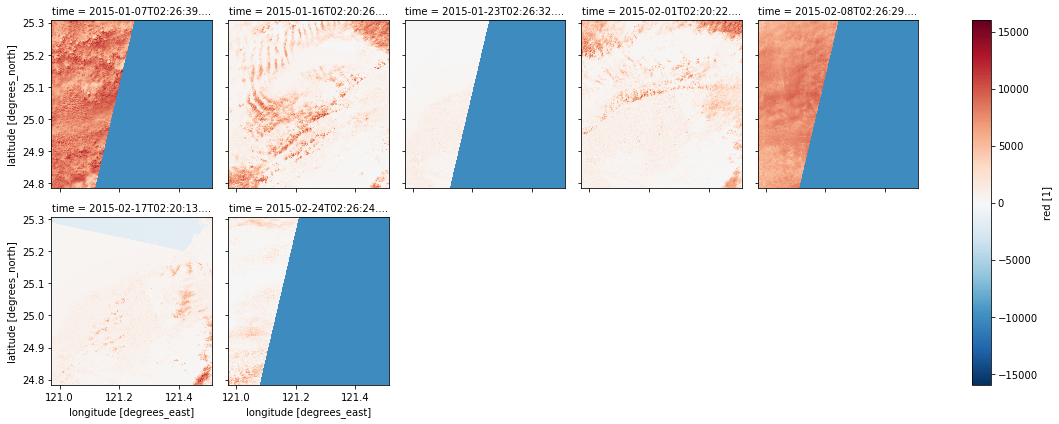

In [15]:
landsat.red.plot(col='time', col_wrap=5)#.where(landsat.green < 1000).plot(col='time', col_wrap=2)

# 4.Save to tiff

In [18]:
import time
import rasterio
import os
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr

def time_to_string(t):
    return time.strftime("%Y_%m_%d_%H_%M_%S", time.gmtime(t.astype(int)/1000000000))

def export_slice_to_geotiff(ds, path):
    write_geotiff_from_xr(path,ds.astype(np.float32),list(ds.data_vars.keys()),crs="EPSG:4326")

#For each time slice in a dataset we call export_slice_to_geotif
def export_xarray_to_geotiff(ds, path):
    for t in ds.time:
        time_slice_xarray = ds.sel(time = t)
        export_slice_to_geotiff(time_slice_xarray, path + "_" + time_to_string(t) + ".tif")
#Start Export
output_dir = "~/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

export_xarray_to_geotiff(landsat, "{}/{}".format(output_dir,product))

In [16]:
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr
import numpy as np
write_geotiff_from_xr("../test.tiff",landsat.sel(time = landsat.time[1]).astype(np.float32),list(landsat.sel(time = landsat.time[1]).data_vars.keys()),crs="EPSG:4326")

# 5.Save to NetCDF

In [19]:
output = landsat.copy()
output.attrs['crs'] = 'EPSG:4326'
for i in list(output.data_vars.keys()):
    output[i].attrs['crs'] = 'EPSG:4326'
output.time.attrs = []
output.pixel_qa.attrs['flags_definition'] = []
output.to_netcdf('test.nc')

In [100]:
!pwd
!ls

/home/h920032/Taiwan_Datacube_Work_Shop
01Load_data.ipynb	 03Xarray_Modify.ipynb	utils
02Dataset_Process.ipynb  test.nc


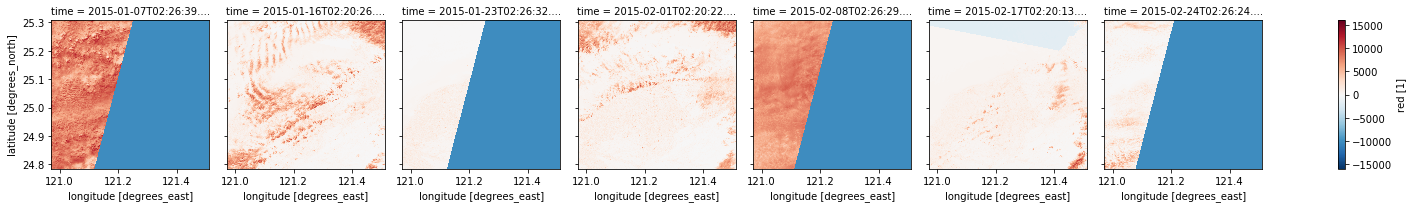

In [20]:
import os
import xarray as xr
path = os.path.abspath('.') 
input_landsat = xr.open_dataset(path + '/test.nc')
input_landsat.red.plot(col = 'time')